In [10]:
import cv2
import numpy as np
image = cv2.imread(r'chest_xray\test\PNEUMONIA\person3_virus_15.jpeg')
image = cv2.resize(image, (180,180), interpolation=cv2.INTER_CUBIC)
image = image / 255.
image = np.array([image])

In [32]:
from keras.models import load_model
model = load_model('pneumoniaMultiClass_Custom.hdf5')
output = model.predict(image)
print(output)

1/1 [==============================] - 0s 63ms/step
[[9.7746481e-05 4.0370971e-02 9.5953125e-01]]


In [13]:
model.summary()

Model: "ChestXRay"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 184, 184, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 178, 178, 16)      2368      
                                                                 
 bn0 (BatchNormalization)    (None, 178, 178, 16)      64        
                                                                 
 activation (Activation)     (None, 178, 178, 16)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 44, 44, 16)        0         
                                                         

In [14]:
convLayers = ['conv0']

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print(pred_index)
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()


gradcamImages = []
for layer in convLayers:
    gradcamImages.append(get_heatmap(image, model, layer))

tf.Tensor(2, shape=(), dtype=int64)


In [58]:
val ='Viral Pneumonia :', '{:.2f}'.format(output[0][1]), 'Bacterial Pneumonia :', '{:.2f}'.format(output[0][2]), 'Normal :',  '{:.2f}'.format(output[0][0])

In [59]:
val = ' '.join(val)
print(val)

Viral Pneumonia : 0.04 Bacterial Pneumonia : 0.96 Normal : 0.00


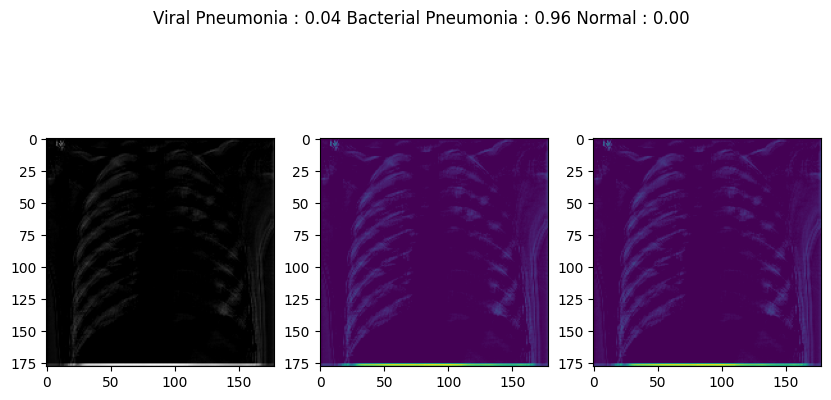

In [60]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle(val)
plt.subplot(1,3,2)
plt.imshow(gradcamImages[0])
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(gradcamImages[0], cv2.COLOR_RGB2BGR))
plt.subplot(1,3,3)
plt.imshow(gradcamImages[0])
plt.show()

In [34]:
output

array([[9.7746481e-05, 4.0370971e-02, 9.5953125e-01]], dtype=float32)